In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import keras
from skimage.transform import resize
from sklearn.utils import resample
from skimage.transform import rotate

# Read Dataset, Transform images

In [7]:
raw_df = pd.read_hdf('../../data/Regression/all_training.h5', 'train_df')
raw_df

,disaster,image,label,height,width,size
0,hurricane-matthew,"[[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...",3,65,54,10530
1,hurricane-matthew,"[[[150, 177, 183], [147, 174, 182], [153, 180,...",0,67,105,21105
2,hurricane-matthew,"[[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...",1,54,56,9072
3,hurricane-matthew,"[[[194, 209, 205], [137, 161, 157], [99, 127, ...",0,114,124,42408
4,hurricane-matthew,"[[[127, 156, 147], [134, 165, 159], [129, 162,...",2,58,51,8874
...,...,...,...,...,...,...
26530,midwest-flooding,"[[[60, 94, 76], [65, 99, 82], [66, 102, 84], [...",0,29,29,2523
26531,midwest-flooding,"[[[84, 122, 114], [87, 120, 116], [87, 117, 11...",0,144,39,16848
26532,midwest-flooding,"[[[53, 80, 57], [55, 81, 60], [60, 86, 66], [6...",0,86,64,16512
26533,midwest-flooding,"[[[39, 69, 43], [39, 69, 44], [39, 69, 44], [3...",0,116,140,48720


### Filter DF
Filter the dataframe to only contain hurricane-matthew

In [8]:
raw_df = raw_df[raw_df["disaster"] == "hurricane-matthew"]
raw_df

,disaster,image,label,height,width,size
0,hurricane-matthew,"[[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...",3,65,54,10530
1,hurricane-matthew,"[[[150, 177, 183], [147, 174, 182], [153, 180,...",0,67,105,21105
2,hurricane-matthew,"[[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...",1,54,56,9072
3,hurricane-matthew,"[[[194, 209, 205], [137, 161, 157], [99, 127, ...",0,114,124,42408
4,hurricane-matthew,"[[[127, 156, 147], [134, 165, 159], [129, 162,...",2,58,51,8874
...,...,...,...,...,...,...
11146,hurricane-matthew,"[[[133, 155, 161], [129, 151, 157], [126, 149,...",3,55,49,8085
11147,hurricane-matthew,"[[[57, 87, 74], [59, 89, 75], [62, 92, 76], [6...",0,80,35,8400
11148,hurricane-matthew,"[[[74, 104, 95], [84, 113, 106], [85, 114, 106...",2,49,45,6615
11149,hurricane-matthew,"[[[64, 97, 83], [78, 112, 98], [79, 111, 98], ...",3,40,46,5520


## Resize the images
Resize the images by padding them to the goal aspect ratio and then resize them to the goal size. This ensures that the images are not smeared and we keep as much original data as possible.

In [9]:
# Parameters
goal_size = (224, 224)

In [10]:
data = pd.DataFrame()

def transform(image):
    target_aspect_ratio = goal_size[0]/goal_size[1] # Target height / target width
    image_height, image_width, _ = image.shape
    current_aspect_ratuo = image_height/image_width
    
    padding = []
    if current_aspect_ratuo > target_aspect_ratio:
        target_width = int(image_height/target_aspect_ratio)
        padding = ((0, 0),((target_width -image_width) // 2, (target_width - image_width) - ((target_width- image_width) // 2)), (0, 0))
    else:
        target_height = int(image_width*target_aspect_ratio)
        padding = (((target_height - image_height) // 2, (target_height - image_height) - ((target_height- image_height) // 2)),(0,0), (0,0))

    new_image = np.pad(image, padding, mode='constant', constant_values=0)
    new_image = resize(new_image, goal_size, anti_aliasing=True)

    return new_image

data["image"] = raw_df["image"].map(lambda image: (transform(image)*255).astype(np.uint8))
data["width"] = [goal_size[1]]*data.shape[0]
data["height"] = [goal_size[0]]*data.shape[0]
data["size"] = [goal_size[0]*goal_size[1]]*data.shape[0]
data["label"] = raw_df["label"]

In [11]:
data.head(10)

,image,width,height,size,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,3
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,0
2,"[[[21, 29, 27], [21, 30, 27], [21, 30, 27], [2...",224,224,50176,1
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,0
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,2
5,"[[[42, 67, 53], [42, 67, 53], [42, 67, 53], [4...",224,224,50176,1
6,"[[[28, 37, 30], [1, 1, 1], [25, 33, 27], [52, ...",224,224,50176,2
7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,1
8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,1
9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,1


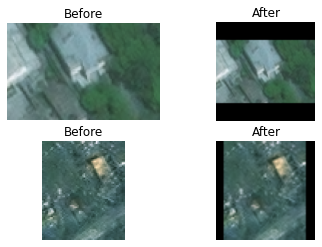

In [12]:
plt.subplot(2, 2, 1)
plt.title("Before")
plt.imshow(raw_df.iloc[1].image)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title("After")
plt.axis('off')
plt.imshow(data.iloc[1].image)
plt.subplot(2, 2, 3)
plt.title("Before")
plt.axis('off')
plt.imshow(raw_df.iloc[0].image)
plt.subplot(2, 2, 4)
plt.title("After")
plt.axis('off')
plt.imshow(data.iloc[0].image)

plt.show()

## Sampling

Use sampling to create a more balanced dataset based on labels

In [13]:
def balance_data(df, n_samples=None, random_state=42):
    balanced_df = pd.DataFrame()
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        if n_samples is None:
            n_samples = len(label_df)
        resampled_df = resample(label_df, replace=True, n_samples=n_samples, random_state=random_state)
        balanced_df = pd.concat([balanced_df, resampled_df], axis=0)
    return balanced_df

In [14]:
print("-------------------------------------")
print("Before sampling data")

disaster_counts = data['label'].value_counts()
print("\nCounts for each label type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)

min_samples = min(data['label'].value_counts())

balanced_df = balance_data(data, n_samples=min_samples)

print("-------------------------------------")
print("After sampling data")

disaster_counts = balanced_df['label'].value_counts()
print("\nCounts for each label type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)


balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df.head(20)

-------------------------------------
Before sampling data

Counts for each label type:
 1    5236
0    2631
3    1740
2    1544
Name: label, dtype: int64

Proportions for each disaster type:
 1    0.469554
0    0.235943
3    0.156040
2    0.138463
Name: label, dtype: float64
-------------------------------------
After sampling data

Counts for each label type:
 3    1544
0    1544
1    1544
2    1544
Name: label, dtype: int64

Proportions for each disaster type:
 3    0.25
0    0.25
1    0.25
2    0.25
Name: label, dtype: float64


,image,width,height,size,label
0,"[[[32, 46, 53], [25, 36, 42], [19, 27, 31], [1...",224,224,50176,0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,2
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,3
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,2
5,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,3
6,"[[[122, 151, 139], [128, 156, 145], [123, 151,...",224,224,50176,0
7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,3
8,"[[[59, 97, 91], [59, 97, 92], [60, 97, 92], [5...",224,224,50176,3
9,"[[[224, 235, 237], [219, 232, 234], [215, 229,...",224,224,50176,3


### Normalize Data

In [15]:
train_df = balanced_df
train_df["image"] = balanced_df["image"]/255

train_df.head(5)

,image,width,height,size,label
0,"[[[0.12549019607843137, 0.1803921568627451, 0....",224,224,50176,0
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",224,224,50176,0
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",224,224,50176,2
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",224,224,50176,3
4,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",224,224,50176,2


# Train / Test Split

In [16]:
float_images = []
for image in train_df["image"].values:
    float_image = np.array(image).astype(np.float32)
    float_images.append(float_image)

float_images = np.array(float_images)

In [17]:
labels_one_hot = keras.utils.to_categorical(train_df["label"].astype(np.float32), num_classes=4)
labels_one_hot[0][0]

1.0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(float_images, labels_one_hot, test_size=0.2)

In [20]:
def rotate_images(X_train, angle):
    num_images = X_train.shape[0]
    rotated_images = []

    for i in range(num_images):
        image = X_train[i]
        rotated_image = rotate(image, angle, preserve_range=True).astype(np.float32)  # Rotate image
        rotated_images.append(rotated_image)

    return np.array(rotated_images)

In [21]:
X_train_rotated = rotate_images(X_train, angle=180)

X_train_combined = np.concatenate([X_train, X_train_rotated], axis=0)

num_rotated_images = X_train_rotated.shape[0]
rotated_labels = y_train[:num_rotated_images] 
y_train_combined = np.concatenate([y_train, rotated_labels], axis=0)

X_train, y_train = shuffle(X_train_combined, y_train_combined, random_state=42)

In [22]:
print(y_train.shape)
print(y_test.shape)

(9880, 4)
(1236, 4)


# Create and Train Models

In [23]:
# Hyper parameters
epochs = 20
batch_size = 64
optimizer = "adam"

datagen = ImageDataGenerator(
        rotation_range=0,  # (degrees, 0 to 180)
        zoom_range = 0, # Randomly Zoom
        width_shift_range=0.1,  # Randomly Shift image % of width
        height_shift_range=0.1,  # Randomly Shift image % of height
        horizontal_flip=False,  # Randomly flip image
        vertical_flip=True)  # Randomly flip image

In [24]:
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)

In [29]:
"""
model = keras.Sequential()
model.add(keras.Input(shape=(124,124,3)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2))) # 64 -> 32

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2))) # 32 -> 16

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2))) # 16 -> 8

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256))
model.add(keras.layers.Dense(124))
model.add(keras.layers.Dense(4, activation="softmax"))
"""
from keras.applications import ResNet50
base_model_1 = ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model = keras.Sequential()
model.add(base_model_1)
model.add(keras.layers.Dense(4, activation="softmax"))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_1 (Dense)             (None, 4)                 4004      
                                                                 
Total params: 25640716 (97.81 MB)
Trainable params: 25587596 (97.61 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [31]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [49]:
model_hist = model.fit(train_gen, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
155/155 [==============================] - 64s 412ms/step - loss: 0.8844 - accuracy: 0.6240 - val_loss: 1.0873 - val_accuracy: 0.5663
Epoch 2/10
155/155 [==============================] - 63s 406ms/step - loss: 0.8753 - accuracy: 0.6274 - val_loss: 1.3609 - val_accuracy: 0.4442
Epoch 3/10
155/155 [==============================] - 63s 406ms/step - loss: 0.8631 - accuracy: 0.6367 - val_loss: 1.1759 - val_accuracy: 0.5000
Epoch 4/10
155/155 [==============================] - 63s 407ms/step - loss: 0.8490 - accuracy: 0.6401 - val_loss: 1.0782 - val_accuracy: 0.5526
Epoch 5/10
155/155 [==============================] - 63s 407ms/step - loss: 0.8482 - accuracy: 0.6455 - val_loss: 1.4398 - val_accuracy: 0.4231
Epoch 6/10
155/155 [==============================] - 63s 408ms/step - loss: 0.8396 - accuracy: 0.6435 - val_loss: 1.1619 - val_accuracy: 0.5008
Epoch 7/10
155/155 [==============================] - 63s 406ms/step - loss: 0.8483 - accuracy: 0.6452 - val_loss: 0.9506 - val_ac

In [145]:
model.save("first_model.keras")

# Evaluate Model and output predictions

In [52]:
raw_test_df = pd.read_hdf('../../data/Regression/test_hurricane.h5')
raw_test_df

,image,size,height,width
0,"[[[118, 140, 143], [113, 135, 138], [110, 132,...",73947,157,157
1,"[[[71, 93, 75], [92, 114, 96], [93, 115, 96], ...",18240,64,95
2,"[[[96, 116, 106], [95, 115, 106], [84, 103, 93...",5772,37,52
3,"[[[51, 87, 58], [57, 97, 65], [61, 103, 69], [...",7830,58,45
4,"[[[113, 133, 136], [125, 145, 149], [109, 131,...",11532,62,62
...,...,...,...,...
2783,"[[[143, 146, 128], [153, 155, 136], [165, 166,...",10788,58,62
2784,"[[[50, 81, 64], [46, 75, 58], [46, 74, 58], [5...",4332,38,38
2785,"[[[69, 97, 91], [73, 103, 99], [74, 104, 101],...",5481,63,29
2786,"[[[110, 125, 121], [120, 136, 133], [123, 138,...",4563,39,39


In [53]:
test_df = pd.DataFrame()
test_df["image"] = raw_test_df["image"].map(lambda image: (transform(image)*255).astype(np.uint8))

In [54]:
test_df["image"] = test_df["image"]/255

In [55]:
test_float_images = []
for image in test_df["image"].values:
    float_image = np.array(image).astype(np.float32)
    test_float_images.append(float_image)

test_float_images = np.array(test_float_images)

In [56]:
predictions = model.predict(test_float_images)
predictions

88/88 [==============================] - 3s 30ms/step


array([[0.11482694, 0.07579552, 0.7675021 , 0.04187539],
       [0.08802803, 0.11317731, 0.7513672 , 0.04742742],
       [0.11885525, 0.13465501, 0.67640585, 0.07008387],
       ...,
       [0.45330215, 0.16442062, 0.20650148, 0.17577575],
       [0.01355056, 0.47358516, 0.46552742, 0.04733688],
       [0.19358426, 0.7073728 , 0.07668123, 0.02236176]], dtype=float32)

In [57]:
predictions_df = pd.DataFrame(np.argmax(predictions, axis=1), columns=['pred'])
predictions_df.to_csv("test_images_hurricane-matthew_predictions.csv", index=False)

In [58]:
len(predictions)

2788

In [51]:
from sklearn.metrics import f1_score
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro')
f1

39/39 [==============================] - 1s 30ms/step


0.6132686084142395

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import keras
from skimage.transform import resize
from sklearn.utils import resample
from skimage.transform import rotate

# Read Dataset, Transform images

In [7]:
raw_df = pd.read_hdf('../../data/Regression/all_training.h5', 'train_df')
raw_df

,disaster,image,label,height,width,size
0,hurricane-matthew,"[[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...",3,65,54,10530
1,hurricane-matthew,"[[[150, 177, 183], [147, 174, 182], [153, 180,...",0,67,105,21105
2,hurricane-matthew,"[[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...",1,54,56,9072
3,hurricane-matthew,"[[[194, 209, 205], [137, 161, 157], [99, 127, ...",0,114,124,42408
4,hurricane-matthew,"[[[127, 156, 147], [134, 165, 159], [129, 162,...",2,58,51,8874
...,...,...,...,...,...,...
26530,midwest-flooding,"[[[60, 94, 76], [65, 99, 82], [66, 102, 84], [...",0,29,29,2523
26531,midwest-flooding,"[[[84, 122, 114], [87, 120, 116], [87, 117, 11...",0,144,39,16848
26532,midwest-flooding,"[[[53, 80, 57], [55, 81, 60], [60, 86, 66], [6...",0,86,64,16512
26533,midwest-flooding,"[[[39, 69, 43], [39, 69, 44], [39, 69, 44], [3...",0,116,140,48720


### Filter DF
Filter the dataframe to only contain hurricane-matthew

In [8]:
raw_df = raw_df[raw_df["disaster"] == "hurricane-matthew"]
raw_df

,disaster,image,label,height,width,size
0,hurricane-matthew,"[[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...",3,65,54,10530
1,hurricane-matthew,"[[[150, 177, 183], [147, 174, 182], [153, 180,...",0,67,105,21105
2,hurricane-matthew,"[[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...",1,54,56,9072
3,hurricane-matthew,"[[[194, 209, 205], [137, 161, 157], [99, 127, ...",0,114,124,42408
4,hurricane-matthew,"[[[127, 156, 147], [134, 165, 159], [129, 162,...",2,58,51,8874
...,...,...,...,...,...,...
11146,hurricane-matthew,"[[[133, 155, 161], [129, 151, 157], [126, 149,...",3,55,49,8085
11147,hurricane-matthew,"[[[57, 87, 74], [59, 89, 75], [62, 92, 76], [6...",0,80,35,8400
11148,hurricane-matthew,"[[[74, 104, 95], [84, 113, 106], [85, 114, 106...",2,49,45,6615
11149,hurricane-matthew,"[[[64, 97, 83], [78, 112, 98], [79, 111, 98], ...",3,40,46,5520


## Resize the images
Resize the images by padding them to the goal aspect ratio and then resize them to the goal size. This ensures that the images are not smeared and we keep as much original data as possible.

In [9]:
# Parameters
goal_size = (224, 224)

In [10]:
data = pd.DataFrame()

def transform(image):
    target_aspect_ratio = goal_size[0]/goal_size[1] # Target height / target width
    image_height, image_width, _ = image.shape
    current_aspect_ratuo = image_height/image_width
    
    padding = []
    if current_aspect_ratuo > target_aspect_ratio:
        target_width = int(image_height/target_aspect_ratio)
        padding = ((0, 0),((target_width -image_width) // 2, (target_width - image_width) - ((target_width- image_width) // 2)), (0, 0))
    else:
        target_height = int(image_width*target_aspect_ratio)
        padding = (((target_height - image_height) // 2, (target_height - image_height) - ((target_height- image_height) // 2)),(0,0), (0,0))

    new_image = np.pad(image, padding, mode='constant', constant_values=0)
    new_image = resize(new_image, goal_size, anti_aliasing=True)

    return new_image

data["image"] = raw_df["image"].map(lambda image: (transform(image)*255).astype(np.uint8))
data["width"] = [goal_size[1]]*data.shape[0]
data["height"] = [goal_size[0]]*data.shape[0]
data["size"] = [goal_size[0]*goal_size[1]]*data.shape[0]
data["label"] = raw_df["label"]

In [11]:
data.head(10)

,image,width,height,size,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,3
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,0
2,"[[[21, 29, 27], [21, 30, 27], [21, 30, 27], [2...",224,224,50176,1
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,0
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,2
5,"[[[42, 67, 53], [42, 67, 53], [42, 67, 53], [4...",224,224,50176,1
6,"[[[28, 37, 30], [1, 1, 1], [25, 33, 27], [52, ...",224,224,50176,2
7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,1
8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,1
9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,1


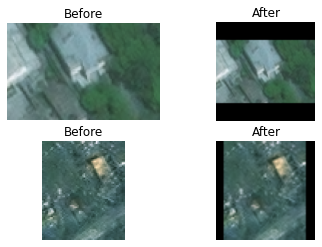

In [12]:
plt.subplot(2, 2, 1)
plt.title("Before")
plt.imshow(raw_df.iloc[1].image)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title("After")
plt.axis('off')
plt.imshow(data.iloc[1].image)
plt.subplot(2, 2, 3)
plt.title("Before")
plt.axis('off')
plt.imshow(raw_df.iloc[0].image)
plt.subplot(2, 2, 4)
plt.title("After")
plt.axis('off')
plt.imshow(data.iloc[0].image)

plt.show()

## Sampling

Use sampling to create a more balanced dataset based on labels

In [13]:
def balance_data(df, n_samples=None, random_state=42):
    balanced_df = pd.DataFrame()
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        if n_samples is None:
            n_samples = len(label_df)
        resampled_df = resample(label_df, replace=True, n_samples=n_samples, random_state=random_state)
        balanced_df = pd.concat([balanced_df, resampled_df], axis=0)
    return balanced_df

In [14]:
print("-------------------------------------")
print("Before sampling data")

disaster_counts = data['label'].value_counts()
print("\nCounts for each label type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)

min_samples = min(data['label'].value_counts())

balanced_df = balance_data(data, n_samples=min_samples)

print("-------------------------------------")
print("After sampling data")

disaster_counts = balanced_df['label'].value_counts()
print("\nCounts for each label type:\n", disaster_counts)

total_records = disaster_counts.sum()
proportions = disaster_counts / total_records
print("\nProportions for each disaster type:\n", proportions)


balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df.head(20)

-------------------------------------
Before sampling data

Counts for each label type:
 1    5236
0    2631
3    1740
2    1544
Name: label, dtype: int64

Proportions for each disaster type:
 1    0.469554
0    0.235943
3    0.156040
2    0.138463
Name: label, dtype: float64
-------------------------------------
After sampling data

Counts for each label type:
 3    1544
0    1544
1    1544
2    1544
Name: label, dtype: int64

Proportions for each disaster type:
 3    0.25
0    0.25
1    0.25
2    0.25
Name: label, dtype: float64


,image,width,height,size,label
0,"[[[32, 46, 53], [25, 36, 42], [19, 27, 31], [1...",224,224,50176,0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,2
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,3
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,2
5,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,3
6,"[[[122, 151, 139], [128, 156, 145], [123, 151,...",224,224,50176,0
7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",224,224,50176,3
8,"[[[59, 97, 91], [59, 97, 92], [60, 97, 92], [5...",224,224,50176,3
9,"[[[224, 235, 237], [219, 232, 234], [215, 229,...",224,224,50176,3


### Normalize Data

In [15]:
train_df = balanced_df
train_df["image"] = balanced_df["image"]/255

train_df.head(5)

,image,width,height,size,label
0,"[[[0.12549019607843137, 0.1803921568627451, 0....",224,224,50176,0
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",224,224,50176,0
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",224,224,50176,2
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",224,224,50176,3
4,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",224,224,50176,2


# Train / Test Split

In [16]:
float_images = []
for image in train_df["image"].values:
    float_image = np.array(image).astype(np.float32)
    float_images.append(float_image)

float_images = np.array(float_images)

In [17]:
labels_one_hot = keras.utils.to_categorical(train_df["label"].astype(np.float32), num_classes=4)
labels_one_hot[0][0]

1.0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(float_images, labels_one_hot, test_size=0.2)

In [20]:
def rotate_images(X_train, angle):
    num_images = X_train.shape[0]
    rotated_images = []

    for i in range(num_images):
        image = X_train[i]
        rotated_image = rotate(image, angle, preserve_range=True).astype(np.float32)  # Rotate image
        rotated_images.append(rotated_image)

    return np.array(rotated_images)

In [21]:
X_train_rotated = rotate_images(X_train, angle=180)

X_train_combined = np.concatenate([X_train, X_train_rotated], axis=0)

num_rotated_images = X_train_rotated.shape[0]
rotated_labels = y_train[:num_rotated_images] 
y_train_combined = np.concatenate([y_train, rotated_labels], axis=0)

X_train, y_train = shuffle(X_train_combined, y_train_combined, random_state=42)

In [22]:
print(y_train.shape)
print(y_test.shape)

(9880, 4)
(1236, 4)


# Create and Train Models

In [23]:
# Hyper parameters
epochs = 20
batch_size = 64
optimizer = "adam"

datagen = ImageDataGenerator(
        rotation_range=0,  # (degrees, 0 to 180)
        zoom_range = 0, # Randomly Zoom
        width_shift_range=0.1,  # Randomly Shift image % of width
        height_shift_range=0.1,  # Randomly Shift image % of height
        horizontal_flip=False,  # Randomly flip image
        vertical_flip=True)  # Randomly flip image

In [24]:
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)

In [29]:
"""
model = keras.Sequential()
model.add(keras.Input(shape=(124,124,3)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2))) # 64 -> 32

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2))) # 32 -> 16

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2))) # 16 -> 8

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256))
model.add(keras.layers.Dense(124))
model.add(keras.layers.Dense(4, activation="softmax"))
"""
from keras.applications import ResNet50
base_model_1 = ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model = keras.Sequential()
model.add(base_model_1)
model.add(keras.layers.Dense(4, activation="softmax"))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_1 (Dense)             (None, 4)                 4004      
                                                                 
Total params: 25640716 (97.81 MB)
Trainable params: 25587596 (97.61 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [31]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [49]:
model_hist = model.fit(train_gen, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
155/155 [==============================] - 64s 412ms/step - loss: 0.8844 - accuracy: 0.6240 - val_loss: 1.0873 - val_accuracy: 0.5663
Epoch 2/10
155/155 [==============================] - 63s 406ms/step - loss: 0.8753 - accuracy: 0.6274 - val_loss: 1.3609 - val_accuracy: 0.4442
Epoch 3/10
155/155 [==============================] - 63s 406ms/step - loss: 0.8631 - accuracy: 0.6367 - val_loss: 1.1759 - val_accuracy: 0.5000
Epoch 4/10
155/155 [==============================] - 63s 407ms/step - loss: 0.8490 - accuracy: 0.6401 - val_loss: 1.0782 - val_accuracy: 0.5526
Epoch 5/10
155/155 [==============================] - 63s 407ms/step - loss: 0.8482 - accuracy: 0.6455 - val_loss: 1.4398 - val_accuracy: 0.4231
Epoch 6/10
155/155 [==============================] - 63s 408ms/step - loss: 0.8396 - accuracy: 0.6435 - val_loss: 1.1619 - val_accuracy: 0.5008
Epoch 7/10
155/155 [==============================] - 63s 406ms/step - loss: 0.8483 - accuracy: 0.6452 - val_loss: 0.9506 - val_ac

In [145]:
model.save("first_model.keras")

# Evaluate Model and output predictions

In [52]:
raw_test_df = pd.read_hdf('../../data/Regression/test_hurricane.h5')
raw_test_df

,image,size,height,width
0,"[[[118, 140, 143], [113, 135, 138], [110, 132,...",73947,157,157
1,"[[[71, 93, 75], [92, 114, 96], [93, 115, 96], ...",18240,64,95
2,"[[[96, 116, 106], [95, 115, 106], [84, 103, 93...",5772,37,52
3,"[[[51, 87, 58], [57, 97, 65], [61, 103, 69], [...",7830,58,45
4,"[[[113, 133, 136], [125, 145, 149], [109, 131,...",11532,62,62
...,...,...,...,...
2783,"[[[143, 146, 128], [153, 155, 136], [165, 166,...",10788,58,62
2784,"[[[50, 81, 64], [46, 75, 58], [46, 74, 58], [5...",4332,38,38
2785,"[[[69, 97, 91], [73, 103, 99], [74, 104, 101],...",5481,63,29
2786,"[[[110, 125, 121], [120, 136, 133], [123, 138,...",4563,39,39


In [53]:
test_df = pd.DataFrame()
test_df["image"] = raw_test_df["image"].map(lambda image: (transform(image)*255).astype(np.uint8))

In [54]:
test_df["image"] = test_df["image"]/255

In [55]:
test_float_images = []
for image in test_df["image"].values:
    float_image = np.array(image).astype(np.float32)
    test_float_images.append(float_image)

test_float_images = np.array(test_float_images)

In [56]:
predictions = model.predict(test_float_images)
predictions

88/88 [==============================] - 3s 30ms/step


array([[0.11482694, 0.07579552, 0.7675021 , 0.04187539],
       [0.08802803, 0.11317731, 0.7513672 , 0.04742742],
       [0.11885525, 0.13465501, 0.67640585, 0.07008387],
       ...,
       [0.45330215, 0.16442062, 0.20650148, 0.17577575],
       [0.01355056, 0.47358516, 0.46552742, 0.04733688],
       [0.19358426, 0.7073728 , 0.07668123, 0.02236176]], dtype=float32)

In [57]:
predictions_df = pd.DataFrame(np.argmax(predictions, axis=1), columns=['pred'])
predictions_df.to_csv("test_images_hurricane-matthew_predictions.csv", index=False)

In [58]:
len(predictions)

2788

In [51]:
from sklearn.metrics import f1_score
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro')
f1

39/39 [==============================] - 1s 30ms/step


0.6132686084142395